In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cfd
import cfdcc
import cfdplot
import cfdsim
import numpy as np

C:\Users\xfernandez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pennylane\operation.py:2631: PennyLaneDeprecationWarning: AnyWires is deprecated and will be removed in v0.43.  If your operation accepts any number of wires, set num_wires=None instead.
  warnings.warn(


In [3]:
def l2(y_true, y_2):
    return np.sqrt(sum([(y_true[k] - y_2[k])**2 for k in range(len(y_true))]))

def linf(y_true, y_2):
    return max([abs(y_true[k] - y_2[k]) for k in range(len(y_true))])

In [4]:
Q_MODE = "lin-seg-qubo"
C_MODE = "lin-seg-np"

In [5]:
def test_var(sim: cfd.Simulation, var_fn, xs):
    psi_l2s = []
    psi_linfs = []
    w_l2s = []
    w_linfs = []
    u_l2s = []
    u_linfs = []
    v_l2s = []
    v_linfs = []

    sim.prepare()
    sim.param["mode"] = C_MODE
    cfdsim.perform_sim(sim)
    psi_b, w_b, u_b, v_b = sim.last_qty()

    for i in range(len(xs)):
        if i > 0:
            var_fn(sim)

        sim.prepare()
        sim.param["mode"] = Q_MODE
        cfdsim.perform_sim(sim)
        psi_a, w_a, u_a, v_a = sim.last_qty()

        psi_l2s.append(l2(psi_a, psi_b))
        psi_linfs.append(linf(psi_a, psi_b))

        w_l2s.append(l2(w_a, w_b))
        w_linfs.append(linf(w_a, w_b))

        u_l2s.append(l2(u_a, u_b))
        u_linfs.append(linf(u_a, u_b))

        v_l2s.append(l2(v_a, v_b))
        v_linfs.append(linf(v_a, v_b))

        print(f"[{xs[i]}] psi-L2={psi_l2s[i]:.3f}, psi-Linf={psi_linfs[i]:.3f} | w-L2={w_l2s[i]:.3f}, w-Linf={w_linfs[i]:.3f} | u-L2={u_l2s[i]:.3f}, u-Linf={u_linfs[i]:.3f} | v-L2={v_l2s[i]:.3f}, v-Linf={v_linfs[i]:.3f}")

    return (psi_l2s, psi_linfs, w_l2s, w_linfs, u_l2s, u_linfs, v_l2s, v_linfs)

In [6]:
minR = 2
maxR = 12
incr = 2

def var_fn(sim: cfd.Simulation):
    sim.param["qubo-R"] += incr

sim = cfd.Simulation({
    "log": cfd.LOG_BASIC,
    "N": 7,
    "L": 1.0,
    "T": 10, "dt": 0.01,
    "nu": 0.1,
    "rho": 1.0,

    "icbc": "tgv",
    "mode": Q_MODE,

    # QUBO
    "qubo-encoding": "dyn",
    "qubo-R": minR,
    "qubo-reads": 1,
    "qubo-strength": 5.0,
    "qubo-chimera-plot": False,
    "qubo-dyn-t-order": 2,
    "qubo-dyn-intv-size": 0,
    "qubo-dyn-psi-base": 1e-1,
    "qubo-dyn-w-base": 1e-2
})

xs = list(range(minR, maxR+incr, incr))
psi_l2s, psi_linfs, w_l2s, w_linfs, u_l2s, u_linfs, v_l2s, v_linfs = test_var(sim, var_fn, xs)

Viscosity: nu=0.1, Re=5 (provided nu)
Constants: alphax=0.03600, alphay=0.03600, beta=0.36000
Re=5
Estimated DNS required gridpoints: N=12>7 used! Potential instability...
Total components (psi+w): 98
Total variables: 98
Variables (psi): 49
Variables (w): 49
BC points psi/w: 0
C(1/10): cx=0.145, cy=0.147
C(2/10): cx=0.134, cy=0.133
C(3/10): cx=0.123, cy=0.122
C(4/10): cx=0.114, cy=0.112
C(5/10): cx=0.106, cy=0.103
C(6/10): cx=0.099, cy=0.096
C(7/10): cx=0.092, cy=0.089
C(8/10): cx=0.086, cy=0.083
C(9/10): cx=0.081, cy=0.078
C(10/10): cx=0.076, cy=0.073
Viscosity: nu=0.1, Re=5 (provided nu)
Constants: alphax=0.03600, alphay=0.03600, beta=0.36000
Re=5
Estimated DNS required gridpoints: N=12>7 used! Potential instability...
Total components (psi+w): 98
Total variables: 98
Variables (psi): 49
Variables (w): 49
BC points psi/w: 0
Estimated R in [7,8]
Parameters, QUBO base: 49*2=98
Parameters, QUBO compiled: 98
[qubo] Q: max=7.5077, min=-6.3163, avg=0.0006
[qubo] Energies: [10.33910049124922

In [7]:
PLOT_PARAMS = False

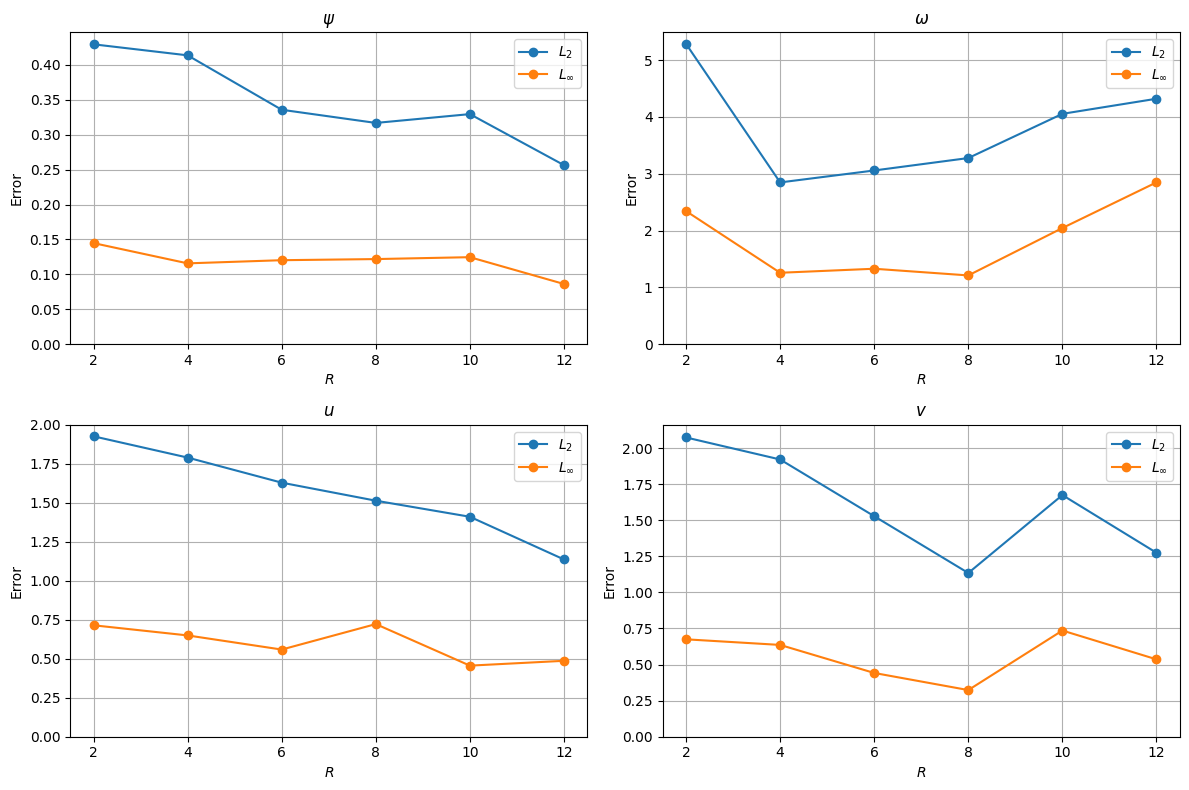

In [8]:
import matplotlib.pyplot as plt

num_rows, num_cols = 2, 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))  # 2x2 grid
axes = axes.flatten()

axes[0].plot(xs, psi_l2s, label='$L_2$', marker='o')
axes[0].plot(xs, psi_linfs, label='$L_\\infty$', marker='o')
axes[0].set_xlabel('$R$')
axes[0].set_ylabel('Error')
axes[0].set_title('$\\psi$')
axes[0].legend()
axes[0].grid(True)
ymin, ymax = axes[0].get_ylim()
axes[0].set_ylim(bottom=0, top=ymax)
axes[0].xaxis.set_major_locator(plt.MultipleLocator(minR, incr))

axes[1].plot(xs, w_l2s, label='$L_2$', marker='o')
axes[1].plot(xs, w_linfs, label='$L_\\infty$', marker='o')
axes[1].set_xlabel('$R$')
axes[1].set_ylabel('Error')
axes[1].set_title('$\\omega$')
axes[1].legend()
axes[1].grid(True)
ymin, ymax = axes[1].get_ylim()
axes[1].set_ylim(bottom=0, top=ymax)
axes[1].xaxis.set_major_locator(plt.MultipleLocator(minR, incr))

axes[2].plot(xs, u_l2s, label='$L_2$', marker='o')
axes[2].plot(xs, u_linfs, label='$L_\\infty$', marker='o')
axes[2].set_xlabel('$R$')
axes[2].set_ylabel('Error')
axes[2].set_title('$u$')
axes[2].legend()
axes[2].grid(True)
ymin, ymax = axes[2].get_ylim()
axes[2].set_ylim(bottom=0, top=ymax)
axes[2].xaxis.set_major_locator(plt.MultipleLocator(minR, incr))

axes[3].plot(xs, v_l2s, label='$L_2$', marker='o')
axes[3].plot(xs, v_linfs, label='$L_\\infty$', marker='o')
axes[3].set_xlabel('$R$')
axes[3].set_ylabel('Error')
axes[3].set_title('$v$')
axes[3].legend()
axes[3].grid(True)
ymin, ymax = axes[3].get_ylim()
axes[3].set_ylim(bottom=0, top=ymax)
axes[3].xaxis.set_major_locator(plt.MultipleLocator(minR, incr))

plt.tight_layout()
plt.show()